In [36]:
from pathlib import Path
thispath = Path.cwd().resolve()
import sys; sys.path.insert(0, str(thispath.parent))

from database.dataset import INBreast_Dataset
import general_utils.utils as utils

import cv2
import random
import torch
import numpy as np
import pandas as pd

from torch.utils.data import DataLoader
from typing import List, Tuple
import torchvision.transforms as T

datapath = thispath.parent / "data" / "INbreast Release 1.0"


class INBreast_Dataset_pytorch(INBreast_Dataset):
    def __init__(
        self, imgpath: Path = datapath/'AllPNGs',
        mask_path: Path = datapath/'AllMasks',
        dfpath: Path = datapath,
        lesion_types: List[str] = ['calcification', 'cluster'],
        transform: List[str] = None,
        data_aug: List[str] = None,
        partitions: List[str] = ['train', 'validation', 'test'],
        extract_patches: bool = True,
        delete_previous: bool = True,
        extract_patches_method: str = 'all',
        patch_size: int = 224,
        stride: Tuple[int] = 100,
        min_breast_fraction_roi: float = 0.7,
        n_jobs: int = -1,
        cropped_imgs: bool = True,
        ignore_diameter_px: int = 15,
        neg_to_pos_ratio: int = None,
        balancing_seed: int = 0
    ):
        super(INBreast_Dataset_pytorch, self).__init__(
            imgpath=imgpath, mask_path=mask_path, dfpath=dfpath, lesion_types=lesion_types,
            transform=transform, data_aug=data_aug, partitions=partitions, delete_previous=delete_previous,
            extract_patches=extract_patches, extract_patches_method=extract_patches_method,
            patch_size=patch_size, stride=stride, min_breast_fraction_roi=min_breast_fraction_roi,
            n_jobs=n_jobs, cropped_imgs=cropped_imgs, ignore_diameter_px=ignore_diameter_px,
            level = 'rois', return_lesions_mask = False, max_lesion_diam_mm = None, use_muscle_mask = False
        )
        self.neg_to_pos_ratio = neg_to_pos_ratio
        self.balancing_seed = balancing_seed
        if neg_to_pos_ratio is not None:
            self.balance_dataset()

    def balance_dataset(self):
        n_pos = self.df.loc[self.df.label=='abnormal', :].shape[0]
        n_neg = len(self.df) - n_pos
        n_to_sample = n_pos * self.neg_to_pos_ratio
        if n_to_sample > n_neg:
            n_to_sample = n_neg
        self.df = pd.concat([
            self.df.loc[self.df.label=='abnormal', :],
            self.df.loc[self.df.label=='abnormal', :].sample(n=n_to_sample, replace=False, random_state=self.balancing_seed)
        ], ignore_index=True)

    def __getitem__(self, idx):
        sample = {}
        sample["label"] = self.labels[idx]

        img_path = self.patch_img_path / self.df['filename'].iloc[idx]
        img = cv2.imread(str(img_path), cv2.IMREAD_ANYDEPTH)
        # Convert all images in left oriented ones
        side = self.df['side'].iloc[idx]
        if side == 'R' and self.level == 'image':
            img = cv2.flip(img, 1)

        img = utils.min_max_norm(img, 1).astype('float32')
        # Apply data augmentations
        # if self.data_aug is not None:
        #     transform_seed = np.random.randint(self.seed)
        #     torch.manual_seed(transform_seed)
        #     img = self.data_aug(img)

        sample['img'] = np.expand_dims(img, 0)

        patch_bbox = self.df['patch_bbox'].iloc[idx]
        if isinstance(patch_bbox, str):
            patch_bbox = utils.load_patch_coords(patch_bbox)
        sample["patch_bbox"] = patch_bbox
        return sample

In [45]:


val_dataset = INBreast_Dataset_pytorch(
        lesion_types = ['calcification', 'cluster'],
        transform = transforms,
        data_aug = None,
        partitions = ['validation'],
        extract_patches = False,
        delete_previous = False,
        extract_patches_method = 'all',
        patch_size = 224,
        stride = 100,
        min_breast_fraction_roi = 0.7,
        n_jobs = -1,
        cropped_imgs = True,
        ignore_diameter_px = 15,
        neg_to_pos_ratio = None
)

val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True, sampler=None,
           batch_sampler=None, num_workers=4, pin_memory=False, drop_last=False)

for i in val_dataloader:
    print(type(i['img']))
    print(i['img'].dtype)
    print(i['img'].shape)
    break

<class 'torch.Tensor'>
torch.float32
torch.Size([1, 1, 224, 224])


In [17]:
i['img']

torch.uint8

In [38]:
transforms = torch.nn.Sequential(
    T.RandomHorizontalFlip(p=0.3),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
)

In [46]:
import matplotlib.pyplot as plt

from torchvision.transforms import InterpolationMode
def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img[0].to('cpu')
        print(img.dtype)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

transforms = torch.nn.ModuleList(
    T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0, hue=0),
    T.RandomAffine(
        degrees=(0, 180), translate=None, scale=(0,10), shear=((2, 2), ()),
        interpolation=InterpolationMode.BILINEAR, fill=0, resample=None
)

transforms = transforms.RandomApply(([]), p=0.3)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
img1 = i['img'].to(device)

transformed_img1 = transforms(img1)
show([transformed_img1])

SyntaxError: invalid syntax (261045667.py, line 19)

In [47]:
# sphinx_gallery_thumbnail_path = "../../gallery/assets/transforms_thumbnail.png"

from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision.transforms as T


plt.rcParams["savefig.bbox"] = 'tight'
orig_img = i['img']
torch.manual_seed(0)

def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

TypeError: Invalid shape (1, 1, 224, 224) for image data

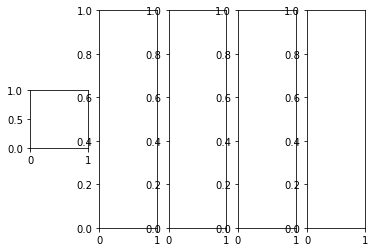

In [48]:
jitter = T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0, hue=0)
jitted_imgs = [jitter(i['img']) for _ in range(4)]
plot(jitted_imgs)

In [ ]:
show([dog1, dog2])

In [11]:
transforms

Sequential(
  (0): ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)
)